In [31]:
import pandas as pd
import numpy as np

In [32]:


df = pd.read_csv("hf://datasets/HitmanH/NCDB_colision/ncdb_merged_filtered.csv")

In [33]:
df_ncdb=df.copy()

In [34]:
df_ncdb['date'] = pd.to_datetime(
        df_ncdb[['C_YEAR', 'C_MNTH', 'C_WDAY']]
        .rename(columns={'C_YEAR': 'year', 'C_MNTH': 'month', 'C_WDAY': 'day'}),
        errors='coerce'
    )

In [35]:
df_ncdb['trauma_score'] = df_ncdb['C_SEV'].map({1: 10, 2: 1}).fillna(0)

In [36]:
national_weekly = (
        df_ncdb.set_index('date')
        .resample('W-MON')['trauma_score']
        .sum()
        .reset_index()
    )
national_weekly.rename(columns={'trauma_score': 'national_index'}, inplace=True)

In [37]:
df_toronto = pd.read_csv("hf://datasets/HitmanH/Toronto_Collision_silver/toronto_collisions_silver.csv")


In [38]:
df_toronto.describe()

,OBJECTID,OCC_DATE,OCC_YEAR,OCC_HOUR,FATALITIES,LONG_WGS84,LAT_WGS84
count,772516.000000,7.725160e+05,772516.000000,772516.000000,772516.000000,646447.000000,646447.000000
mean,386258.500000,1.570185e+12,2019.256124,13.493745,0.000860,-79.391659,43.713111
std,223006.304614,1.077741e+11,3.414332,4.978853,0.030219,0.100555,0.054491
min,1.000000,1.388552e+12,2014.000000,0.000000,0.000000,-79.639247,43.586487
25%,193129.750000,1.479877e+12,2016.000000,10.000000,0.000000,-79.462648,43.665466
50%,386258.500000,1.557720e+12,2019.000000,14.000000,0.000000,-79.392133,43.711802
75%,579387.250000,1.669612e+12,2022.000000,17.000000,0.000000,-79.315234,43.759049
max,772516.000000,1.759205e+12,2025.000000,23.000000,4.000000,-79.122044,43.853164


In [39]:
print(df_toronto['OCC_DATE'].head())

0    1388552400000
1    1388552400000
2    1388552400000
3    1388552400000
4    1388552400000
Name: OCC_DATE, dtype: int64


In [40]:
df_toronto['date'] = pd.to_datetime(df_toronto['OCC_DATE'], unit='ms')

In [41]:
df_toronto = df_toronto.dropna(subset=['date'])

In [43]:
def calc_score(row):
        if 'FATALITIES' in row and row['FATALITIES'] > 0:
            return 10  # Fatal
        elif 'INJURY_COLLISIONS' in row and row['INJURY_COLLISIONS'] == 'YES':
            return 1   # Injury
        else:
            return 0 # No Injury

In [44]:
df_toronto['trauma_score'] = df_toronto.apply(calc_score, axis=1)

In [ ]:
df_toronto = df_toronto.dropna(subset=['date'])

In [45]:
toronto_weekly = (
        df_toronto.set_index('date')
        .resample('W-MON')['trauma_score']
        .sum()
        .reset_index()
    )

In [46]:
toronto_weekly.rename(columns={'trauma_score': 'y', 'date': 'ds'}, inplace=True)

In [47]:
print(f"Toronto data processed. Rows: {len(toronto_weekly)}")
   
print(f"Date Range: {toronto_weekly['ds'].min()} to {toronto_weekly['ds'].max()}")

Toronto data processed. Rows: 614
Date Range: 2014-01-06 00:00:00 to 2025-10-06 00:00:00


In [48]:
df_master = pd.merge(toronto_weekly, national_weekly, left_on='ds', right_on='date', how='left')

In [49]:
df_master.drop(columns=['date'], inplace=True)

--- VALIDATION REPORT ---
Date Range: 2014-01-06 00:00:00 to 2025-10-06 00:00:00
Total Weeks: 614
Missing National Index Values: 199 weeks


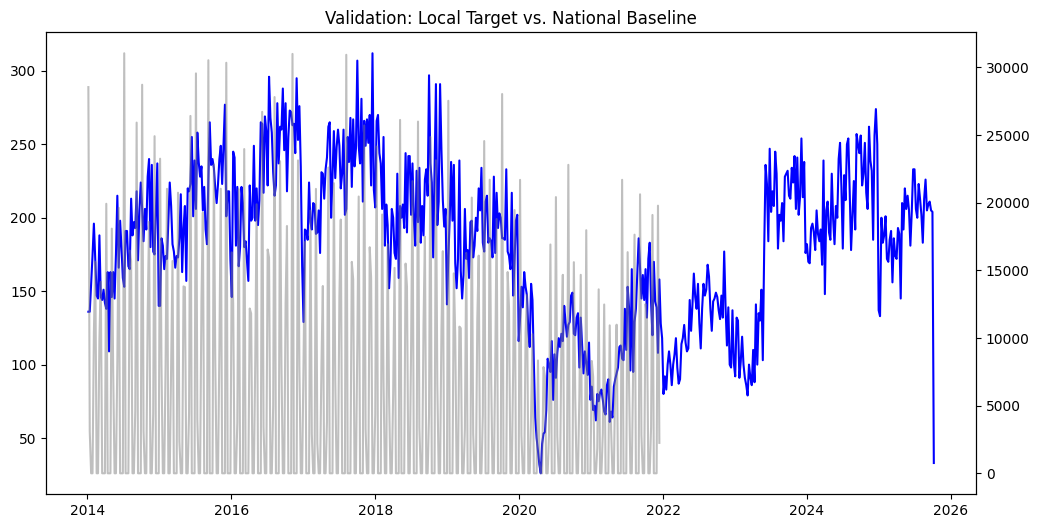

In [51]:
import matplotlib.pyplot as plt

def validate_master_data(df):
    print("--- VALIDATION REPORT ---")
    
    # 1. Check Date Ranges
    print(f"Date Range: {df['ds'].min()} to {df['ds'].max()}")
    print(f"Total Weeks: {len(df)}")
    

    missing_national = df['national_index'].isna().sum()
    print(f"Missing National Index Values: {missing_national} weeks")
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label='Toronto Target (y)', color='blue')
    ax2 = plt.gca().twinx()
    ax2.plot(df['ds'], df['national_index'], label='National Baseline', color='grey', alpha=0.5)
    plt.title("Validation: Local Target vs. National Baseline")
    plt.show()

# Run the validation
validate_master_data(df_master)

In [52]:
df_master['week_of_year'] = df_master['ds'].dt.isocalendar().week

In [53]:
seasonal_profile = df_master.dropna(subset=['national_index']).groupby('week_of_year')['national_index'].mean()

In [54]:
def fill_missing_national(row):
    if pd.isna(row['national_index']):
        # If missing, use the historical average for that specific week number
        return seasonal_profile.get(row['week_of_year'], row['national_index']) 
    return row['national_index']

In [55]:
df_master['national_index'] = df_master.apply(fill_missing_national, axis=1)

In [56]:
print(f"Missing National Index after fix: {df_master['national_index'].isna().sum()}")

Missing National Index after fix: 0


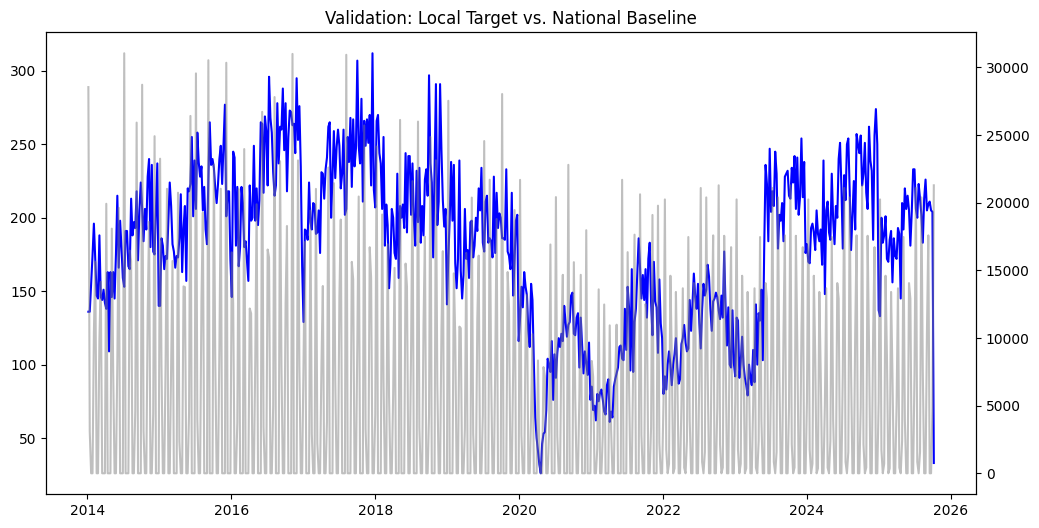

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(df_master['ds'], df_master['y'], label='Toronto Target (y)', color='blue')
ax2 = plt.gca().twinx()
ax2.plot(df_master['ds'], df_master['national_index'], label='National Baseline', color='grey', alpha=0.5)
plt.title("Validation: Local Target vs. National Baseline")
plt.show()

In [59]:
df_master.describe()

,ds,y,national_index,week_of_year
count,614,614.000000,614.000000,614.0
mean,2019-11-21 12:00:00,181.314332,5994.490257,26.260586
min,2014-01-06 00:00:00,26.000000,0.000000,1.0
25%,2016-12-13 18:00:00,143.250000,0.000000,13.0
50%,2019-11-21 12:00:00,188.000000,0.000000,26.0
75%,2022-10-29 06:00:00,221.000000,11311.500000,39.0
max,2025-10-06 00:00:00,312.000000,31039.000000,53.0
std,NaN,54.849673,8159.109341,14.924623


In [60]:
import holidays

In [61]:
ca_holidays = holidays.CA(years=range(2014, 2026))

In [62]:
def is_holiday_week(date):
    # Check if any day in that week (Mon-Sun) is a holiday
    week_dates = [date + pd.Timedelta(days=i) for i in range(7)]
    for d in week_dates:
        if d in ca_holidays:
            return 1
    return 0

In [63]:
df_master['is_holiday'] = df_master['ds'].apply(is_holiday_week)

In [65]:
df_master.describe()

,ds,y,national_index,week_of_year,is_holiday
count,614,614.000000,614.000000,614.0,614.000000
mean,2019-11-21 12:00:00,181.314332,5994.490257,26.260586,0.099349
min,2014-01-06 00:00:00,26.000000,0.000000,1.0,0.000000
25%,2016-12-13 18:00:00,143.250000,0.000000,13.0,0.000000
50%,2019-11-21 12:00:00,188.000000,0.000000,26.0,0.000000
75%,2022-10-29 06:00:00,221.000000,11311.500000,39.0,0.000000
max,2025-10-06 00:00:00,312.000000,31039.000000,53.0,1.000000
std,NaN,54.849673,8159.109341,14.924623,0.299373


In [67]:
df_master.to_csv("../../data/silver/NCDB_Toront_holiday_merged/toronto_ncdb_master.csv")